# Анализ популярного сервиса аренды самокатов GoFast

Исследование данных о пользователях из нескольких городов, а также об их поездках на самокатах. Анализ данных и проверка гипотез, которые могут помочь бизнесу вырасти.

**Описание данных**

**Пользователи** — users_go.csv

**user_id**	- уникальный идентификатор пользователя

**name** - имя пользователя

**age** - возраст

**city** - город

**subscription_type** - тип подписки (free, ultra)

**Поездки** — rides_go.csv

**user_id** - уникальный идентификатор пользователя

**distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)

**duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

**date** - дата совершения поездки

**Подписки** — subscriptions_go.csv

**subscription_type** - тип подписки

**minute_price** - стоимость одной минуты поездки по данной подписке

**start_ride_price** - стоимость начала поездки

**subscription_fee** - стоимость ежемесячного платежа


### Загрузка данных

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import pandas as pd

In [80]:
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

In [81]:
display(users_go.head())
print(' ')
users_go.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [82]:
display(rides_go.head())
print(' ')
rides_go.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [83]:
display(subscriptions_go.head())
print(' ')
subscriptions_go.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Пропущенных значений нет.

###  Предобработка данных

In [84]:
#Приводим столбец date к типу даты pandas
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')
#Создаём новый столбец с номером месяца на основе столбца date
rides_go ['month'] = rides_go['date'].dt.month
display (rides_go.head())

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [85]:
#Проверяем наличие дубликатов в датафреймах.
print(users_go.duplicated().sum())
print(rides_go.duplicated().sum())
print(subscriptions_go.duplicated().sum())

31
0
0


Выявлены явные дубликаты в датафрейме users_go, удалим их

In [86]:
duplicated_users_go = users_go[users_go.duplicated()]
users_go = users_go.drop_duplicates().reset_index(drop=True)
print(users_go.duplicated().sum())

0


In [87]:
print(users_go['user_id'].unique())
print(users_go['name'].unique())
print(users_go['city'].unique())
print(users_go['subscription_type'].unique())

[   1    2    3 ... 1532 1533 1534]
['Кира' 'Станислав' 'Алексей' 'Константин' 'Адель' 'Регина' 'Игорь' 'Юрий'
 'Ян' 'Валерий' 'Агата' 'Марк' 'Ева' 'Антонина' 'Валерия' 'Амалия'
 'Даниил' 'Аделина' 'Святогор' 'Борис' 'Вероника' 'Ростислав' 'Назар'
 'Эдуард' 'Василий' 'Денис' 'Тамара' 'Николай' 'Эвелина' 'Федор' 'Руслан'
 'Иван' 'Любовь' 'Ярослава' 'Майя' 'Ильдар' 'Данила' 'Нина' 'Стефания'
 'Ясмина' 'Дмитрий' 'Александр' 'Одиссей' 'Арсений' 'Алла' 'Таисия'
 'Максим' 'Юлиана' 'Павел' 'Карина' 'Алиса' 'Лидия' 'Рамиль' 'Родион'
 'Ника' 'Оксана' 'Анастасия' 'Маргарита' 'Вера' 'Тимур' 'Никита' 'Лев'
 'Влад' 'Артур' 'Анна' 'Ольга' 'Вячеслав' 'Ксения' 'Виталина' 'Владислав'
 'Тамерлан' 'Амина' 'Вадим' 'Олеся' 'Зарина' 'Егор' 'Гордей' 'Лилия'
 'Святослав' 'Роберт' 'Амир' 'Влада' 'Богдан' 'Полина' 'Марат' 'Елисей'
 'Макар' 'Алина' 'Глеб' 'Андрей' 'Альбина' 'Людмила' 'Марсель' 'Милена'
 'Диана' 'Дарина' 'Данил' 'Артемий' 'Лиана' 'Альберт' 'Герман' 'Жанна'
 'Нелли' 'Евгения' 'Ариана' 'Самира' 'За

Неявных дубликатов не обнаружено. 

### Исследовательский анализ данных

**Частота встречаемости городов**

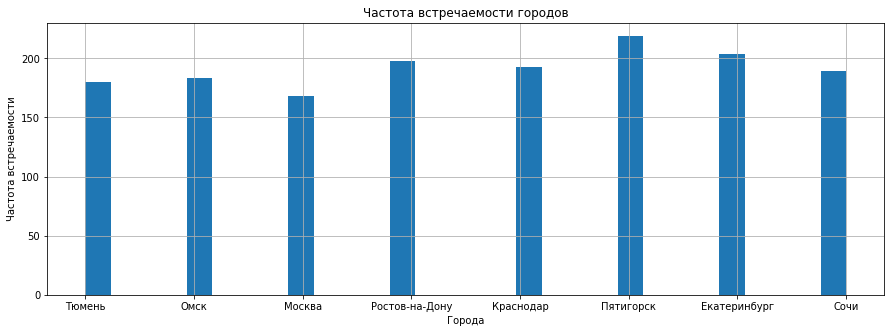

In [88]:
users_go['city'].hist(bins=30, figsize=(15,5))
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Частота встречаемости')
plt.show()

По гистограмме видно, что наиболее часто встречается город Пятигорск, реже всего Москва

**Cоотношение пользователей с подпиской и без подписки**

In [89]:
users_ratio_ultra = users_go['subscription_type'].value_counts().loc['ultra'] / len(users_go)
users_ratio_free = users_go['subscription_type'].value_counts().loc['free'] / len(users_go)
print('Соотношение пользователей с подпиской', users_ratio_ultra)
print('Соотношение пользователей без подписки',users_ratio_free)

Соотношение пользователей с подпиской 0.4556714471968709
Соотношение пользователей без подписки 0.5443285528031291


45.6% составляют люди с подпиской, 54.4% - люди без подписки.

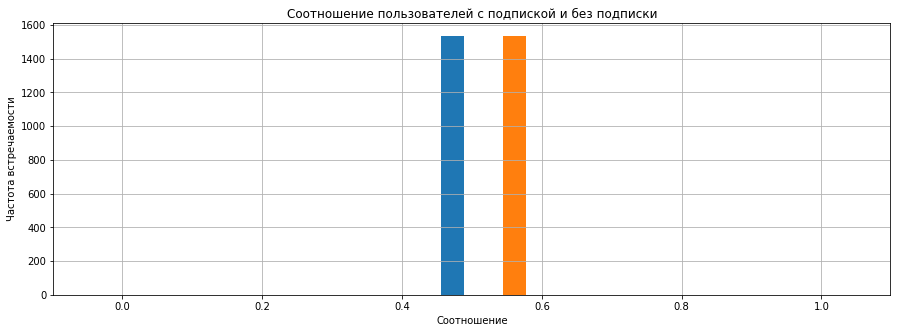

In [90]:
users_go['users_ratio_ultra'] = users_ratio_ultra
users_go['users_ratio_free'] = users_ratio_free
users_go['users_ratio_ultra'].hist(bins=30, figsize=(15,5))
users_go['users_ratio_free'].hist(bins=30, figsize=(15,5))
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel('Соотношение')
plt.ylabel('Частота встречаемости')
plt.show()

**Возраст пользователей**

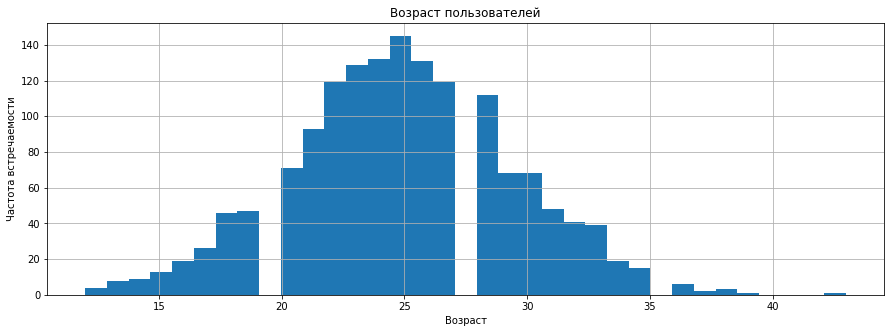

In [91]:
users_go['age'].hist(bins=35, figsize=(15,5))
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота встречаемости')
plt.show()

Чаще всего встречаются люди в возрасте 24-25 лет, старше 35 пользователей практически нет.

**Расстояние, которое пользователь преодолел за одну поездку**

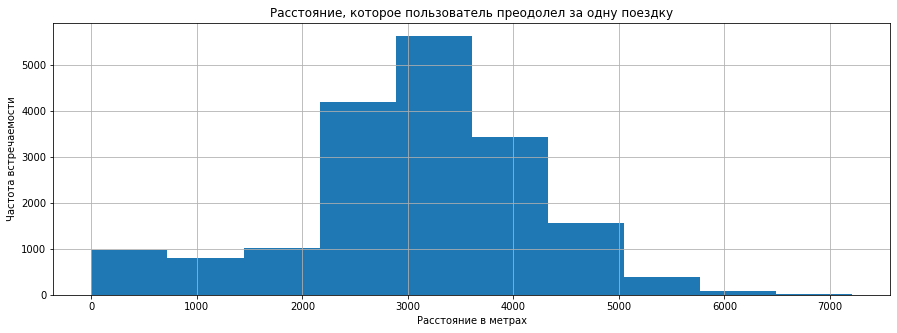

In [92]:
rides_go['distance'].hist(figsize=(15,5))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота встречаемости')
plt.show()

На гистрограмме видно, что встречаются значения дистанции на самокате менее 1000 метров и более 5000 метров, чаще всего пользователи едут на самокате расстояния 3000-3500 метров.

**Продолжительность поездок**

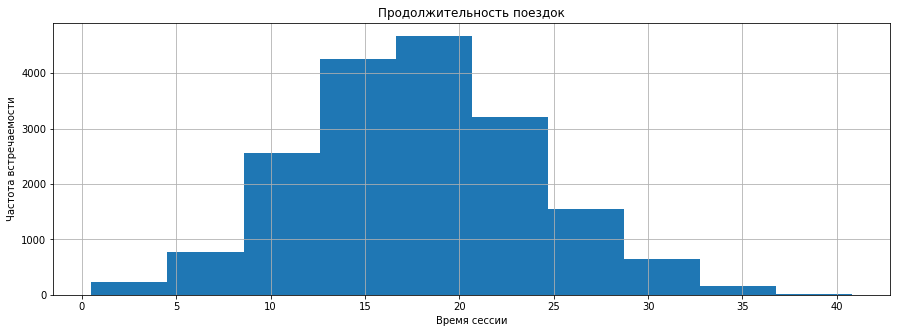

In [93]:
rides_go['duration'].hist(figsize=(15,5))
plt.title('Продолжительность поездок')
plt.xlabel('Время сессии')
plt.ylabel('Частота встречаемости')
plt.show()

По гистрограмме видно, что чаще всего продолжительность сессии длится 16-21 минут.

### Объединение данных

**4.1 Объединение данных о пользователях, поездках и подписках**

In [94]:
data = users_go.merge(rides_go, on='user_id', how = 'left')
final_data = data.merge(subscriptions_go, on='subscription_type', how = 'left')
display(final_data)

,user_id,name,age,city,subscription_type,users_ratio_ultra,users_ratio_free,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,0.455671,0.544329,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,0.455671,0.544329,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,0.455671,0.544329,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,0.455671,0.544329,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,0.455671,0.544329,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,0.455671,0.544329,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,0.455671,0.544329,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,0.455671,0.544329,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,0.455671,0.544329,2902.308661,16.674362,2021-11-27,11,8,50,0


**4.2 Создание двух датафреймов из датафрейма, созданного на этапе 4.1**

**c данными о пользователях без подписки:**

In [95]:
data_free = final_data.groupby('subscription_type').get_group('free')
display(data_free)

,user_id,name,age,city,subscription_type,users_ratio_ultra,users_ratio_free,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,0.455671,0.544329,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,0.455671,0.544329,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,0.455671,0.544329,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,0.455671,0.544329,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,0.455671,0.544329,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,0.455671,0.544329,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,0.455671,0.544329,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,0.455671,0.544329,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,0.455671,0.544329,2902.308661,16.674362,2021-11-27,11,8,50,0


**с данными о пользователях с подпиской:**

In [96]:
data_ultra = final_data.groupby('subscription_type').get_group('ultra')
display(data_ultra)

,user_id,name,age,city,subscription_type,users_ratio_ultra,users_ratio_free,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,0.455671,0.544329,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,0.455671,0.544329,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,0.455671,0.544329,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,0.455671,0.544329,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,0.455671,0.544329,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,0.455671,0.544329,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,0.455671,0.544329,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,0.455671,0.544329,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,0.455671,0.544329,4707.845501,15.839579,2021-10-17,10,6,0,199


**4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий**

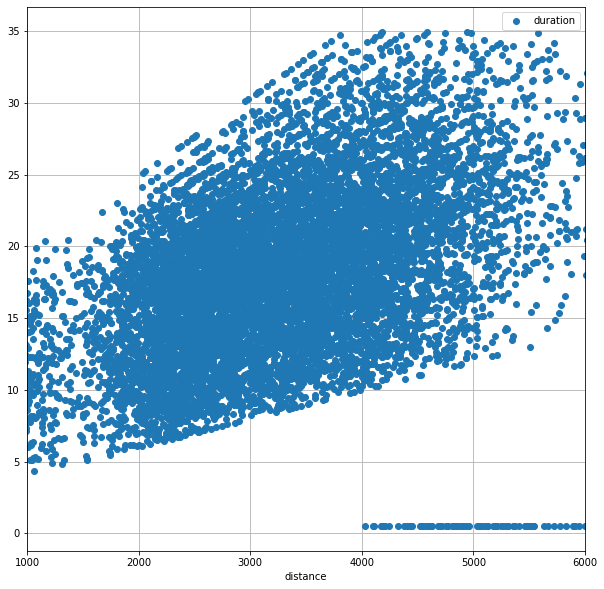

In [97]:
data_free.plot(x='distance', y='duration', style='o',xlim=(1000,6000), grid=True, figsize=(10,10))
plt.show()

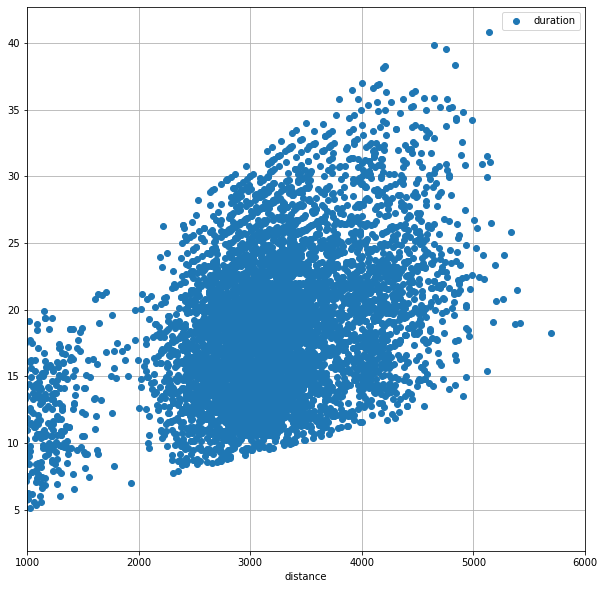

In [98]:
data_ultra.plot(x='distance', y='duration', style='o',xlim=(1000,6000), grid=True, figsize=(10,10))
plt.show()

Вполне логично: чем меньше времени идёт сессия, тем меньшее расстояние пройдено, больше времени = большее расстояние.

### Подсчёт выручки

**5.1 Создаём датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: находим суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц**

In [99]:
agg_data = final_data.pivot_table(index=['user_id', 'month'], values = ['distance', 'duration', 'name', 'subscription_type'], aggfunc={'distance':'sum', 'duration':'sum', 'name':'count', 'subscription_type': 'min'})
agg_data.columns = ['total_distance', 'total_duration','rides_count', 'subscription_type']
agg_data = agg_data.reset_index()
agg_data['total_duration']= np.ceil(agg_data['total_duration'])
display(agg_data)

,user_id,month,total_distance,total_duration,rides_count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,45.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,54.0,3,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,25.0,2,free
11327,1534,8,7622.453034,48.0,2,free
11328,1534,9,4928.173852,23.0,1,free
11329,1534,11,13350.015305,77.0,4,free


**5.2 В этот же датафрейм добавляем столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обращаемся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки**

In [100]:
def income_func (row):
    if row['subscription_type'] == 'ultra':
        return 6*row['total_duration']+199
    if row['subscription_type'] == 'free':
        return 8*row['total_duration']+ 50*row['rides_count']

agg_data['income'] = agg_data.apply(income_func, axis=1)  
display(agg_data)

,user_id,month,total_distance,total_duration,rides_count,subscription_type,income
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,45.0,2,ultra,469.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,54.0,3,ultra,523.0
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,25.0,2,free,300.0
11327,1534,8,7622.453034,48.0,2,free,484.0
11328,1534,9,4928.173852,23.0,1,free,234.0
11329,1534,11,13350.015305,77.0,4,free,816.0


### Проверка гипотез

**6.1 Тратят ли пользователи с подпиской больше времени на поездки? Проверяем гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.**

H0 - data_ultra['duration'] = data_free['duration] (пользователи с подпиской тратят столько же времени на поездку, как и пользователи без подписки)

H1 - data_ultra['duration'] != data_free['duration]; data_ultra['duration'] > data_free['duration] - (пользователи c подпиской по времени поездки различаются с пользователями без подписки; пользователи с подпиской тратят больше времени на поездку, чем пользователи без подписки)

In [77]:
alpha = 0.05
first_group = data_ultra['duration']
second_group = data_free['duration']
results = st.ttest_ind(first_group, second_group, alternative='greater')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем гипотезу


Получается, что пользователи с подпиской, скорее всего, тратят больше времени на поездку, чем пользователи без подписки.

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверяем гипотезу и делаем выводы.**

H0 - data_ultra['distance'] = 3130 (пользователи с подпиской проезжают за одну поездку 3130 метров)

H1 - data_ultra['distance'] < 3130 ((пользователи с подпиской проезжают за одну поездку расстояние, не превышающее 3130 метров)


In [101]:
distance_ultra = data_ultra['distance']
optimal_value = 3130
alpha = 0.05
results = st.ttest_1samp(distance_ultra, optimal_value, alternative='less')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-value: 0.08046311521502146
Не получилось отвергнуть гипотезу


Сказать, что пользователи с подпиской проезжают за одну поездку расстояние, не превышающее 3130 метров, нельзя.

**6.3. Проверяем гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.**

H0 - income_ultra = income_free (помесячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки)

H1 - income_ultra != income_free; income_ultra > income_free ((помесячная выручка от пользователей с подпиской различается с помесячной выручкой пользователей без подписки; помесячная выручка пользователей с подпиской больше, чем помесячная выручка пользователей без подписки)

In [103]:
income_ultra = agg_data.groupby('subscription_type').get_group('ultra')
income_ultra = income_ultra['income']
print(income_ultra)
income_free = agg_data.groupby('subscription_type').get_group('free')
income_free = income_free['income']
print(income_free)

0       451.0
1       241.0
2       469.0
3       391.0
4       523.0
        ...  
4528    301.0
4529    469.0
4530    385.0
4531    295.0
4532    355.0
Name: income, Length: 4533, dtype: float64
4533     170.0
4534     938.0
4535     202.0
4536     178.0
4537     332.0
         ...  
11326    300.0
11327    484.0
11328    234.0
11329    816.0
11330    178.0
Name: income, Length: 6798, dtype: float64


In [104]:
alpha= 0.05
results = st.ttest_ind(income_ultra, income_free, alternative = 'greater')
print(f'p-value:{results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-value:2.8130926188487286e-35
Отвергаем гипотезу


Получается, что помесячная выручка от пользователей с подпиской больше, чем помесячная выручка от пользователей без подписки. 

**6.4. Ситуация: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Вопрос: какой тест вам понадобился бы для проверки этой гипотезы?**

Ответ: это гипотеза о равенстве средних для зависимых (парных) выборок, будет применён ttest с двумя параметрами: наборы данных до и после обновления:

results = st.ttest_rel(before, after)

### Вывод

Были проанализированы данные о пользователях и их поездках на самокате GoFast из нескольких городов.

В результате исследования было выявлено, что чаще всего самокатами GoFast пользуются в городе Пятигорске, используют подписку Ultra 45,6% людей, чаще всего пользователями приложения являются люди в возрасте 24-25 лет, чаще всего расстояние, которое они проезжают на самокате, это 3000-3500 метров, а длительность сессии на самокате чаще всего равна 16-21 минут. 

В результате проверок нескольких гипотез стало понятно, что:

1) пользователи мобильного приложения GoFast с подпиской Ultra, скорее всего, тратят больше времени на поездку, чем пользователи без подписки;

2) пользователи мобильного приложения GoFast с подпиской Ultra проезжают за одну поездку расстояние, оптимальное с точки зрения износа самоката - 3130 метров;

3) помесячная выручка от пользователей мобильного приложения GoFast с подпиской Ultra больше, чем помесячная выручка от пользователей без подписки. 

А это значит, что продакт-менеджеры сервиса могут проводить различные акции для увеличения количества пользователей с подпиской, что повлечёт за собой большую помесячную выручку для GoFast.
